# SPR single model predictions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, average_precision_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
color = sns.color_palette()

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [5]:
from load_data import TARGET_LABELS, load_month

Load 2015-01 - 2015-05 as training and test on 2015-06

In [6]:
train = pd.DataFrame()
for i in range(5):
    df = load_month(i, True)
    train = pd.concat([train, df], axis=0)
    
test = load_month(5, True)

In [11]:
print train.shape, test.shape

(1250000, 45) (250000, 45)


Add new columns 'target_value', 'target_value_diff'

In [12]:
def dummies_to_decimal(row):
    output = ''
    for v in row.values:
        output += str(int(v))
    return log(int(output,2)+1)

In [13]:
train.loc[:, 'target_value'] = train[TARGET_LABELS].apply(dummies_to_decimal, axis=1)
test.loc[:, 'target_value'] = test[TARGET_LABELS].apply(dummies_to_decimal, axis=1)

Encode categorical columns

In [16]:
def encode_cat_data(df):
    string_data = df.select_dtypes(include=["object"])
    for c in string_data.columns:
        le = LabelEncoder()    
        le.fit(df[c])
        df[c] = le.transform(df[c])

In [17]:
encode_cat_data(train)

Define training data and targets

~~- X_train, X_test : all columns of `train` dataset after train_test_split~~

~~- Y_train, Y_test : `TARGET_LABELS` of `test` dataset after train_test_split~~

- Get unique clients from `test` dataset
- Keep rows for these




In [14]:
def transform_data(X):
    date_cols = ['fecha_dato', 'fecha_alta']
    out = X.drop(date_cols, axis=1)
    out['duration'] = (X['fecha_dato'] - X['fecha_alta']).dt.days
    cols = out.columns
    out = pd.DataFrame(StandardScaler().fit_transform(out), columns=cols)
    return out

In [18]:
X = transform_data(train)
Y = test[TARGET_LABELS]

In [20]:
print X.shape, Y.shape

(1250000, 45) (250000, 24)


In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)

ValueError: Found input variables with inconsistent numbers of samples: [1250000, 250000]

In [ ]:
print X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

In [54]:
rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, verbose = 0)

In [55]:
rf.fit(X_train, Y_train)
score = rf.score(X_train, Y_train)
print score

0.999696


In [56]:
Y_pred = rf.predict(X_test)
print average_precision_score(Y_test, Y_pred)

0.634559655909


2) Train on all features and targets from a month as data, take TARGET_LABELS of the next month as Y_train

In [95]:
X_train = transform_data(train_month_1)
X_test = transform_data(train_month_2)
Y_train = train_month_2[TARGET_LABELS]
Y_test = train_month_3[TARGET_LABELS]

In [61]:
rf = RandomForestClassifier(n_estimators = 250, n_jobs = -1, verbose = 0)

In [62]:
rf.fit(X_train, Y_train)
score = rf.score(X_train, Y_train)
print score

1.0


In [63]:
Y_pred = rf.predict(X_test)

ValueError: Found input variables with inconsistent numbers of samples: [628354, 250000]

In [65]:
print Y_pred.shape, Y_test.shape

(250000, 24) (628354, 24)


In [87]:
mask1 = train_month_3['ncodpers'].isin(train_month_2['ncodpers'])
mask2 = train_month_2['ncodpers'].isin(train_month_3['ncodpers'])
Y_test_rd = Y_test[mask1]
Y_pred_rd = pd.DataFrame(Y_pred)[mask2]
print Y_test_rd.shape, Y_pred_rd.shape

(249438, 24) (249438, 24)


In [89]:
print average_precision_score(Y_test_rd, Y_pred_rd)

0.0704053710202


Feature ranking:
1. feature 0 'ncodpers' (0.204563)
2. feature 43 'duration' (0.179916)
3. feature 42 'logrenta' (0.163221)
4. feature 4 'age' (0.126760)
5. feature 15 'nomprov' (0.088124)
6. feature 13 'canal_entrada' (0.053968)
7. feature 3 'sexo' (0.021667)
8. feature 17 'segmento' (0.015290)
9. feature 20 'ind_cco_fin_ult1' (0.013514)
10. feature 25 'ind_ctop_fin_ult1' (0.011349)
11. feature 16 'ind_actividad_cliente' (0.010288)
12. feature 9 'tiprel_1mes' (0.010283)
13. feature 30 'ind_ecue_fin_ult1' (0.009976)
14. feature 41 'ind_recibo_ult1' (0.009972)
15. feature 35 'ind_reca_fin_ult1' (0.008522)
16. feature 29 'ind_dela_fin_ult1' (0.008381)
17. feature 26 'ind_ctpp_fin_ult1' (0.007534)
18. feature 36 'ind_tjcr_fin_ult1' (0.007032)
19. feature 11 'indext' (0.006979)
20. feature 37 'ind_valo_fin_ult1' (0.006365)
21. feature 31 'ind_fond_fin_ult1' (0.005264)
22. feature 22 'ind_cno_fin_ult1' (0.004967)
23. feature 40 'ind_nom_pens_ult1' (0.003446)
24. feature 33 'ind_plan_fin_ult

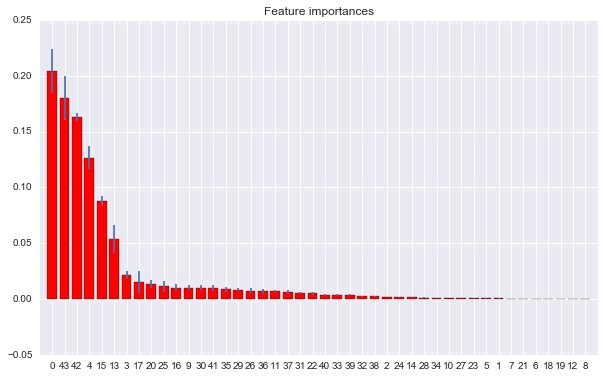

In [97]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
features = X_train.columns.values

for f in range(X.shape[1]):
    print("%d. feature %d '%s' (%f)" % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
def run_cv(data, targets, clf, cv=10):
    X0 = data
    y = targets
    X = StandardScaler().fit_transform(X0)
    scores = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(mape_error))
    print scores      
    print scores.mean(), scores.std()

In [45]:
help(average_precision_score)

Help on function average_precision_score in module sklearn.metrics.ranking:

average_precision_score(y_true, y_score, average='macro', sample_weight=None)
    Compute average precision (AP) from prediction scores
    
    This score corresponds to the area under the precision-recall curve.
    
    Note: this implementation is restricted to the binary classification task
    or multilabel classification task.
    
    Read more in the :ref:`User Guide <precision_recall_f_measure_metrics>`.
    
    Parameters
    ----------
    y_true : array, shape = [n_samples] or [n_samples, n_classes]
        True binary labels in binary label indicators.
    
    y_score : array, shape = [n_samples] or [n_samples, n_classes]
        Target scores, can either be probability estimates of the positive
        class, confidence values, or non-thresholded measure of decisions
        (as returned by "decision_function" on some classifiers).
    
    average : string, [None, 'micro', 'macro' (default), 